In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from io import StringIO
import numpy as np
from sklearn.metrics import r2_score

In [2]:
def find_skip_rows(results_file: Path) -> int:
    """
    Open the result benchmark, and locate the actual start of the timings

    Returns:
    --------
    skiprows (int): the number of lines to skip when read_csv is called
    """
    skiprows = 0
    with open(results_file, 'r') as f:
        while ('name,iterations,' not in f.readline()):
            skiprows += 1

    return skiprows

In [3]:
!ls results/

bench_byref_pod.csv		    bench_normalizeAngle.csv
bench_byref_pod.png		    bench_PassStringVal_vs_Ref.csv
bench_Checksum.csv		    bench_pod.csv
bench_embedded.csv		    bench_stl_parallel2.csv
bench_emplace2.csv		    bench_stl_parallel2.png
bench_emplace3.csv		    bench_stl_parallel.csv
bench_emplace.csv		    bench_stl_parallel.png
bench_EnumMapOfMap.csv		    bench_vectorAppend2.csv
bench_EnumMapOfMap.png		    bench_vectorAppend.csv
bench_eplus.csv			    bench_vectorOfObjects.csv
bench_eplus_empty_v_int_vector.csv  Checksum_Benchmark.csv
bench_eplus_empty_v_int_vector.png  Model_Benchmark.csv
bench_eplus.png


# Analyze One

In [4]:
results_file = 'results/bench_EnumMapOfMap.csv'
#results_file = 'results/Checksum_Benchmark.csv'
df = pd.read_csv(results_file, skiprows=find_skip_rows(results_file), index_col=0)
BASE_CASE = 'BM_Current'
assert BASE_CASE in df.index.str.split('/', expand=True).get_level_values(0)

In [5]:
df = df.loc[df['iterations'].notnull()]

In [6]:
# Convert everything in ms
for col in ['real_time', 'cpu_time']:
    df[col] = df[[col, 'time_unit']].apply(lambda row: pd.to_timedelta(arg=row[0], unit=row[1]), axis=1).dt.total_seconds() * 1e3

In [7]:
df[['test_case', 'n']] = df.index.to_series().str.split('/', n=1, expand=True)
df['n'] = df['n'].astype('int')
df['real_time/n'] = df['real_time'] / df['n']

In [8]:
df.set_index(['test_case', 'n'], inplace=True)

In [9]:
test_order = list(df.index.get_level_values(0).unique())
assert BASE_CASE in test_order
# Ensure base base is first
test_order.remove(BASE_CASE)
test_order.insert(0, BASE_CASE)

In [10]:
df['real_time']

test_case          n     
BM_Current         8            0.082378
                   16           0.165387
                   64           0.668677
                   256          2.701450
                   1024        10.659700
                                ...     
BM_ArrayConstexpr  4096        35.912000
                   16384      142.936000
                   65536      572.075000
                   262144    2294.060000
                   524288    4562.080000
Name: real_time, Length: 80, dtype: float64

Text(0.5, 1.0, 'real_time / old(real_time)')

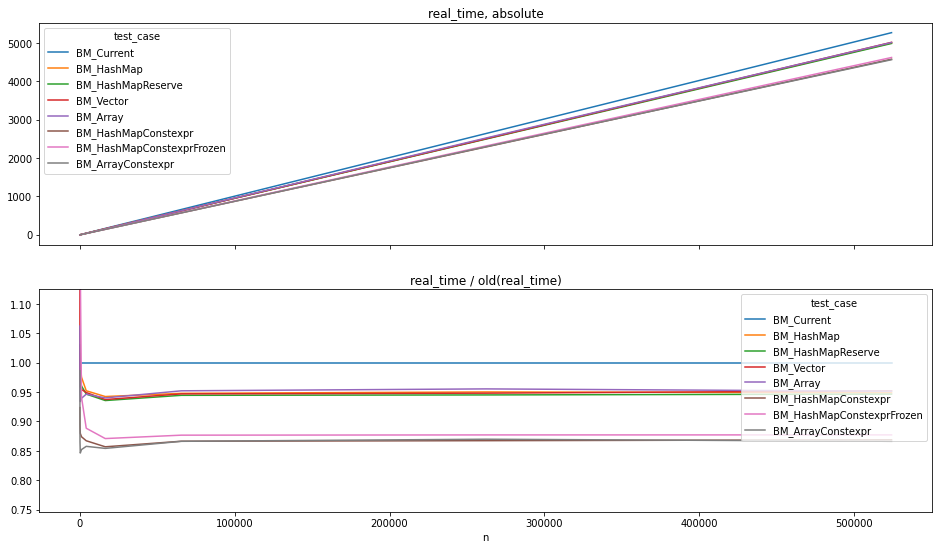

In [11]:
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(16, 9), sharex=True)

toplot = df['real_time'].unstack(0)[test_order]
toplot.plot(ax=ax0)
ax0.set_title('real_time, absolute')
toplot_rel = toplot.div(toplot[BASE_CASE], axis=0)
toplot_rel.plot(ax=ax1)

rel_min = toplot_rel.stack().min() - 0.1
# mean = toplot_rel.stack().mean()
# std = toplot_rel.stack().std()
# rel_max = mean + std
rel_max = np.quantile(toplot_rel.values, q=0.95)

ax1.set_ylim(rel_min, rel_max)
ax1.set_title('real_time / old(real_time)')

<AxesSubplot: xlabel='test_case', ylabel='n'>

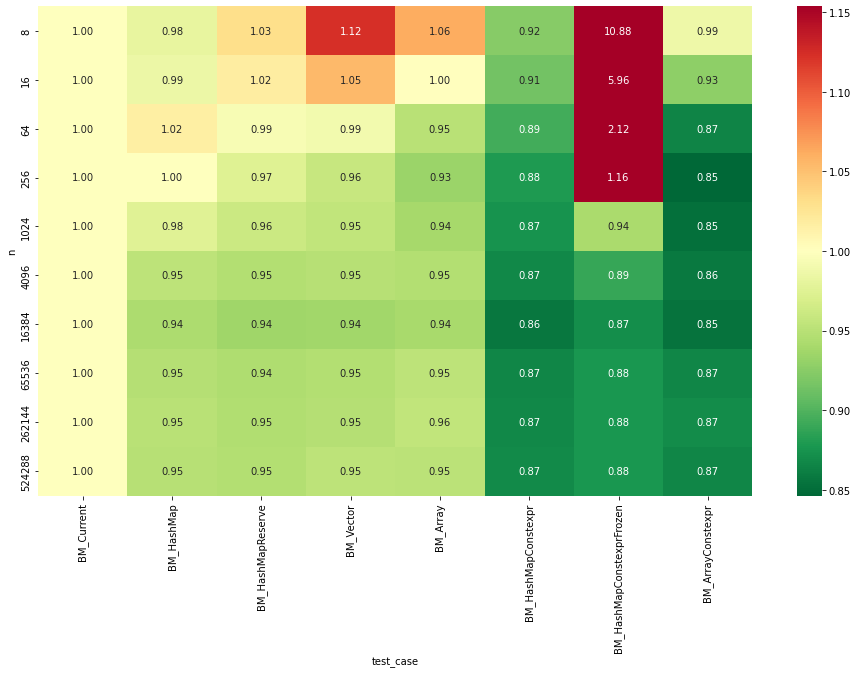

In [12]:
fig, ax = plt.subplots(figsize=(16, 9))
annot_rel = True
vmin_rel = toplot_rel.min().min()
sns.heatmap(toplot_rel, ax=ax, cmap='RdYlGn_r', 
            annot=toplot_rel if annot_rel else toplot,
            fmt=".2f",
            vmin=vmin_rel,
            vmax=2 - vmin_rel
)

<AxesSubplot: xlabel='n'>

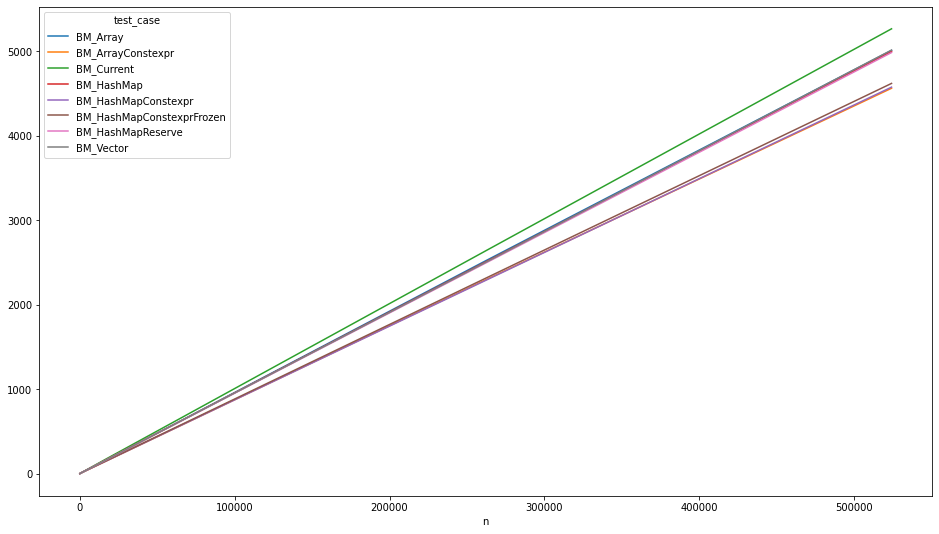

In [13]:
df['real_time'].unstack(0).plot(figsize=(16, 9))

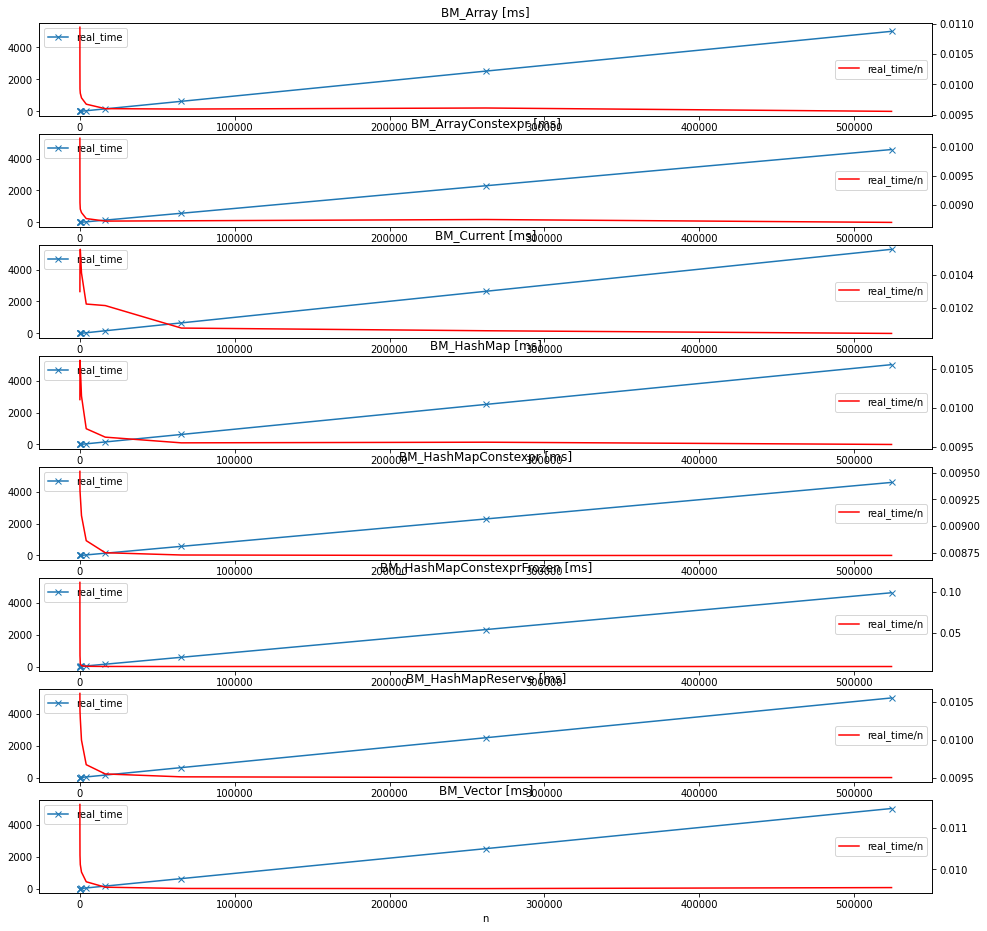

In [14]:
relative = False
grouped = df.groupby('test_case')

ncols = 1
nrows = int(np.ceil(grouped.ngroups/ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 2*nrows), sharey=True)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    toplot = grouped.get_group(key).loc[key, ['real_time', 'real_time/n']]
    if relative:
        toplot = toplot / toplot.iloc[0]
    
    toplot[['real_time']].plot(ax=ax, marker='x')
    ax.set_title(f"{key} [ms]")
    axbis = ax.twinx()
    toplot[['real_time/n']].plot(ax=axbis, label='real_time/n', c='r')

    ax.legend()
    axbis.legend(loc='right')
    
plt.show()

# Interpolate

In [15]:
test_case = BASE_CASE
test_case = 'BM_ArrayConstexpr'
df_test = df.loc[test_case].copy()

fit_infos = {}
for deg in [1, 2]:
    
    # p, residuals, rank, singular_values, rcond = np.polyfit(df_test.index, df_test['real_time'], deg=2, full=True)
    p = np.polyfit(df_test.index, df_test['real_time'], deg=deg)

    r2 = r2_score(df_test['real_time'], df_test.index.to_series().apply(lambda x: np.polyval(p, x)))
    fit_infos[deg] = {'p': p, 'r2': r2}
    
    if p.size == 2:
        fit_infos[deg]['equation'] = f"y = {p[0]}*x + {p[1]}"
    elif p.size == 3:
        fit_infos[deg]['equation'] = f"y = {p[0]}*x**2 + {p[1]}*x + {p[2]}"
        
best_deg = max(fit_infos.keys(), key=(lambda key: fit_infos[key]['r2']))
p = fit_infos[best_deg]['p']
r2 = fit_infos[best_deg]['r2']
equation = fit_infos[best_deg]['equation']
print(f"Best Polynomial degree={best_deg}, r2={r2:.3f}, {equation}")

Best Polynomial degree=2, r2=1.000, y = -1.7044194134877314e-10*x**2 + 0.008792195579949272*x + -0.4170156362614188


In [16]:
df_test

,iterations,real_time,cpu_time,time_unit,bytes_per_second,items_per_second,label,error_occurred,error_message,real_time/n
n,,,,,,,,,,
8,8488.0,0.081240,0.081235,ms,NaN,NaN,NaN,NaN,NaN,0.010155
16,4528.0,0.153423,0.153412,ms,NaN,NaN,NaN,NaN,NaN,0.009589
64,1172.0,0.578623,0.578589,ms,NaN,NaN,NaN,NaN,NaN,0.009041
256,306.0,2.286430,2.286290,ms,NaN,NaN,NaN,NaN,NaN,0.008931
1024,77.0,9.084050,9.083830,ms,NaN,NaN,NaN,NaN,NaN,0.008871
4096,19.0,35.912000,35.909400,ms,NaN,NaN,NaN,NaN,NaN,0.008768
16384,5.0,142.936000,142.926000,ms,NaN,NaN,NaN,NaN,NaN,0.008724
65536,1.0,572.075000,572.045000,ms,NaN,NaN,NaN,NaN,NaN,0.008729
262144,1.0,2294.060000,2293.940000,ms,NaN,NaN,NaN,NaN,NaN,0.008751


In [17]:
fit_infos

{1: {'p': array([0.00870943, 0.88049554]),
  'r2': 0.9999936453541239,
  'equation': 'y = 0.008709432890442624*x + 0.8804955404991976'},
 2: {'p': array([-1.70441941e-10,  8.79219558e-03, -4.17015636e-01]),
  'r2': 0.9999993994291546,
  'equation': 'y = -1.7044194134877314e-10*x**2 + 0.008792195579949272*x + -0.4170156362614188'}}

In [18]:
def r_squared(y, y_hat):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

In [19]:
r_squared(df_test['real_time'], df_test.index.to_series().apply(lambda x: np.polyval(p, x)))

0.9999993994291546

In [20]:
(df_test.index[-1] - df_test.index[-2]) / df_test.index[-2]

1.0

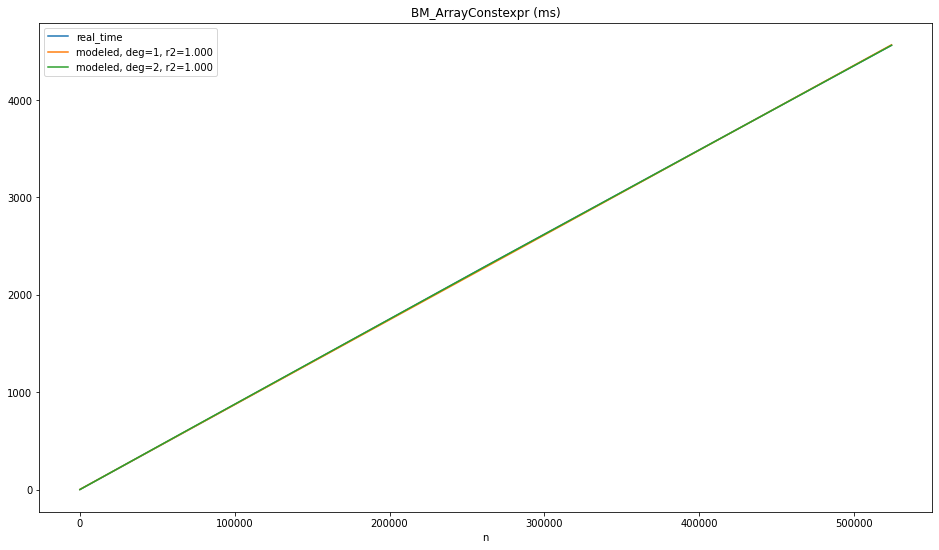

In [21]:
fig, ax = plt.subplots(figsize=(16, 9))
df_test[['real_time']].plot(ax=ax)
#df_test.index.to_series().apply(lambda x: p[0]*x**2 + p[1]*x + p[2]).plot()

for deg, fit_info in fit_infos.items():
    r2 = fit_info['r2']
    df_test.index.to_series().apply(lambda x: np.polyval(fit_info['p'], x)).plot(label=f'modeled, {deg=}, r2={r2:.3f}')
    ax.legend()
    ax.set_title(f'{test_case} (ms)')

<AxesSubplot: xlabel='n'>

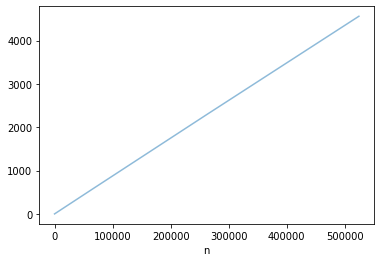

In [22]:
df_test.index.to_series().apply(lambda x: np.polyval(p, x)).plot(label='modeled', alpha=0.5)